# What is neural style transfer in a layman's language?

We have seen and used filters in our cameras and day-to-day life. We apply some filters to our images and something magical happens. We see a different picture altogether. This is the same with the case of Neural Style Transfer. Technically speaking, a style of an image is built upon a base image, thus, giving us a style-transferred image.

In [2]:
import pandas as pd 
import numpy as np
import os
from keras import backend as K
from keras.preprocessing.image import load_img, save_img, img_to_array
import matplotlib.pyplot as plt
from keras.applications import vgg19
from keras.models import Model

from scipy.optimize import fmin_l_bfgs_b

print(os.listdir("../input"))

#  I am performing this on kaggle, hence, the different nomenclature

Using TensorFlow backend.


['best-artworks-of-all-time', 'vgg19', 'image-classification']


In [3]:
StylePath = '../input/best-artworks-of-all-time/images/images/'
ContentPath = '../input/image-classification/validation/validation/travel and adventure/'

## Loading the path for Base Content Image and the Style image respectively

In [4]:
base_image_path = ContentPath+'13.jpg'
style_image_path = StylePath+'Pablo_Picasso/Pablo_Picasso_92.jpg'

In [5]:
# dimensions of the generated picture.
width, height = load_img(base_image_path).size
img_nrows = 400
img_ncols = int(width * img_nrows / height)

I am using VGG19 for this task. I am trying to preprocess the images for this particular network.

In [6]:
def preprocess_image(image_path):
    from keras.applications import vgg19
    img = load_img(image_path, target_size=(img_nrows, img_ncols))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg19.preprocess_input(img)
    return img

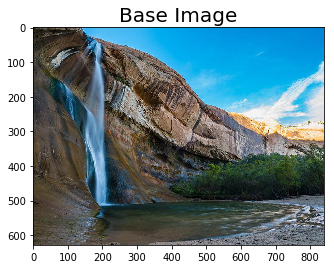

In [7]:
plt.figure()
plt.title("Base Image",fontsize=20)
img1 = load_img(ContentPath+'13.jpg')
plt.imshow(img1)

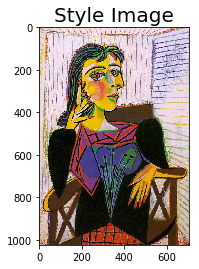

In [8]:
plt.figure()
plt.title("Style Image",fontsize=20)
img1 = load_img(StylePath+'Pablo_Picasso/Pablo_Picasso_92.jpg')
plt.imshow(img1)

In [9]:
# get tensor representations of our images

base_image = K.variable(preprocess_image(base_image_path))
style_reference_image = K.variable(preprocess_image(style_image_path))

Instructions for updating:
Colocations handled automatically by placer.


In [10]:
K.image_data_format()

'channels_last'

### this will contain our generated image

Think of **Variable** in tensorflow as a normal variables which we use in programming languages. We initialize variables, we can modify it later as well. Whereas **placeholder** doesn’t require initial value. Placeholder simply allocates block of memory for future use. Later, we can use feed_dict to feed the data into placeholder. By default, placeholder has an unconstrained shape, which allows you to feed tensors of different shapes in a session.

In [11]:
# this will contain our generated image
if K.image_data_format() == 'channels_first':
    combination_image = K.placeholder((1,3,img_nrows, img_ncols))
else:
    combination_image = K.placeholder((1,img_nrows, img_ncols,3))

In [12]:
# combine the 3 images into a single Keras tensor
input_tensor = K.concatenate([base_image,
                              style_reference_image,
                              combination_image
                              ], axis=0)

## Building the VGG19 model

In [13]:
# build the VGG19 network with our 3 images as input
# the model will be loaded with pre-trained ImageNet weights
from keras.applications.vgg19 import VGG19
vgg19_weights = '../input/vgg19/vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5'
model = VGG19(input_tensor=input_tensor,
              include_top = False,
              weights=vgg19_weights)
#model = vgg19.VGG19(input_tensor=input_tensor,
#                    weights='imagenet', include_top=False)
print('Model loaded.')


Model loaded.


VGG19 is mainly used for classification, thus, we modify the layer that are used for only classification.

In [14]:
# Content layer where will pull our feature maps
content_layers = ['block5_conv2'] 

# Style layer we are interested in
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1',
                'block5_conv1'
               ]

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

In [15]:
outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])
print(outputs_dict['block5_conv2'])

Tensor("block5_conv2/Relu:0", shape=(3, 25, 33, 512), dtype=float32)



![Coontent Loss](https://cdn-images-1.medium.com/max/800/1*1YfGhmzBw7EK3e8CRpZbuA.png)

In [16]:
# an auxiliary loss function
# designed to maintain the "content" of the
# base image in the generated image
def get_content_loss(base_content, target):
    return K.sum(K.square(target - base_content))


![Gram Matrix](https://cdn-images-1.medium.com/max/800/1*5xx9KmhVb59Mxe_buOwHBA.png)

![Style loss](https://cdn-images-1.medium.com/max/800/1*PuYveCM2BlgFfjUCr6I_Ng.png)

In [17]:
import tensorflow as tf

def gram_matrix(input_tensor):
    assert K.ndim(input_tensor)==3
   
    channels = int(input_tensor.shape[-1])
    a = tf.reshape(input_tensor, [-1, channels])
    n = tf.shape(a)[0]
    gram = tf.matmul(a, a, transpose_a=True)
    return gram#/tf.cast(n, tf.float32)

def get_style_loss(style, combination):
    assert K.ndim(style) == 3
    assert K.ndim(combination) == 3
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = img_nrows*img_ncols
    return K.sum(K.square(S - C))
    

In [18]:
content_weight=0.025 
style_weight=1.0
# combine these loss functions into a single scalar
loss = K.variable(0.0)
layer_features = outputs_dict['block5_conv2']
base_image_features = layer_features[0, :, :, :]
combination_features = layer_features[2, :, :, :]
print('Layer Feature for Content Layers :: '+str(layer_features))
print('Base Image Feature :: '+str(base_image_features))
print('Combination Image Feature for Content Layers:: '+str(combination_features)+'\n')
loss += content_weight * get_content_loss(base_image_features,
                                      combination_features)

feature_layers = ['block1_conv1', 'block2_conv1',
                  'block3_conv1', 'block4_conv1',
                  'block5_conv1']
for layer_name in feature_layers:
    layer_features = outputs_dict[layer_name]
    style_reference_features = layer_features[1, :, :, :]
    combination_features = layer_features[2, :, :, :]
    print('Layer Feature for Style Layers :: '+str(layer_features))
    print('Style Image Feature :: '+str(style_reference_features))
    print('Combination Image Feature for Style Layers:: '+str(combination_features)+'\n')
    sl = get_style_loss(style_reference_features, combination_features)
    loss += (style_weight / len(feature_layers)) * sl


Layer Feature for Content Layers :: Tensor("block5_conv2/Relu:0", shape=(3, 25, 33, 512), dtype=float32)
Base Image Feature :: Tensor("strided_slice:0", shape=(25, 33, 512), dtype=float32)
Combination Image Feature for Content Layers:: Tensor("strided_slice_1:0", shape=(25, 33, 512), dtype=float32)

Layer Feature for Style Layers :: Tensor("block1_conv1/Relu:0", shape=(3, 400, 535, 64), dtype=float32)
Style Image Feature :: Tensor("strided_slice_2:0", shape=(400, 535, 64), dtype=float32)
Combination Image Feature for Style Layers:: Tensor("strided_slice_3:0", shape=(400, 535, 64), dtype=float32)

Layer Feature for Style Layers :: Tensor("block2_conv1/Relu:0", shape=(3, 200, 267, 128), dtype=float32)
Style Image Feature :: Tensor("strided_slice_6:0", shape=(200, 267, 128), dtype=float32)
Combination Image Feature for Style Layers:: Tensor("strided_slice_7:0", shape=(200, 267, 128), dtype=float32)

Layer Feature for Style Layers :: Tensor("block3_conv1/Relu:0", shape=(3, 100, 133, 256), 

In [19]:
def deprocess_image(x):
    if K.image_data_format() == 'channels_first':
        x = x.reshape((3, img_nrows, img_ncols))
        x = x.transpose((1, 2, 0))
    else:
        x = x.reshape((img_nrows, img_ncols, 3))
    
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68

    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [20]:

grads = K.gradients(loss, combination_image)
grads

[<tf.Tensor 'gradients/concat_grad/Slice_2:0' shape=(1, 400, 535, 3) dtype=float32>]

In [21]:
outputs = [loss]
if isinstance(grads, (list,tuple)):
    outputs += grads
else:
    outputs.append(grads)
f_outputs = K.function([combination_image], outputs)
f_outputs

In [22]:

x_opt = preprocess_image(base_image_path)

In [23]:
def eval_loss_and_grads(x):
    if K.image_data_format() == 'channels_first':
        x = x.reshape((1, 3, img_nrows, img_ncols))
    else:
        x = x.reshape((1, img_nrows, img_ncols, 3))
    outs = f_outputs([x])
    loss_value = outs[0]
    if len(outs[1:]) == 1:
        grad_values = outs[1].flatten().astype('float64')
    else:
        grad_values = np.array(outs[1:]).flatten().astype('float64')
    return loss_value, grad_values


In [24]:
class Evaluator(object):

    def __init__(self):
        self.loss_value = None
        self.grads_values = None

    def loss(self, x):
        assert self.loss_value is None
        loss_value, grad_values = eval_loss_and_grads(x)
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value

    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values

In [25]:
evaluator = Evaluator()

In [26]:
iterations=50
# Store our best result
best_loss, best_img = float('inf'), None
for i in range(iterations):
    print('Start of iteration', i)
    x_opt, min_val, info= fmin_l_bfgs_b(evaluator.loss, 
                                        x_opt.flatten(), 
                                        fprime=evaluator.grads,
                                        maxfun=20,
                                        disp=True,
                                       )
    print('Current loss value:', min_val)
    if min_val < best_loss:
        # Update best loss and best image from total loss. 
        best_loss = min_val
        best_img = x_opt.copy()

Start of iteration 0
Current loss value: 4.934218e+21
Start of iteration 1
Current loss value: 2.1479157e+21
Start of iteration 2
Current loss value: 1.441731e+21
Start of iteration 3
Current loss value: 1.12333074e+21
Start of iteration 4
Current loss value: 9.4671026e+20
Start of iteration 5
Current loss value: 8.045047e+20
Start of iteration 6
Current loss value: 6.947181e+20
Start of iteration 7
Current loss value: 6.208275e+20
Start of iteration 8
Current loss value: 5.6491458e+20
Start of iteration 9
Current loss value: 5.188731e+20
Start of iteration 10
Current loss value: 4.6697895e+20
Start of iteration 11
Current loss value: 4.2518878e+20
Start of iteration 12
Current loss value: 3.9980674e+20
Start of iteration 13
Current loss value: 3.778245e+20
Start of iteration 14
Current loss value: 3.549003e+20
Start of iteration 15
Current loss value: 3.3544077e+20
Start of iteration 16
Current loss value: 3.2047e+20
Start of iteration 17
Current loss value: 3.0437912e+20
Start of ite

**The Final Image**

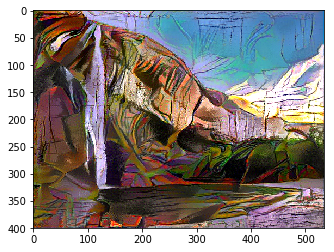

In [27]:
# save current generated image
imgx = deprocess_image(best_img.copy())
plt.imshow(imgx)

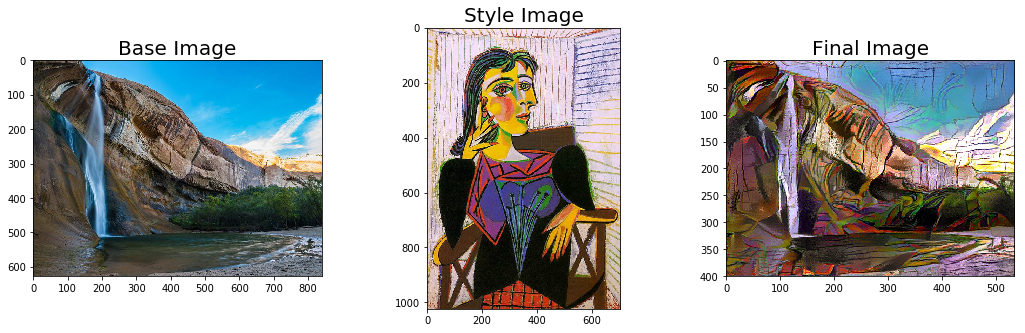

In [28]:
plt.figure(figsize=(30,30))
plt.subplot(5,5,1)
plt.title("Base Image",fontsize=20)
img_base = load_img(base_image_path)
plt.imshow(img_base)

plt.subplot(5,5,1+1)
plt.title("Style Image",fontsize=20)
img_style = load_img(style_image_path)
plt.imshow(img_style)

plt.subplot(5,5,1+2)
plt.title("Final Image",fontsize=20)
plt.imshow(imgx)

This function **Run_Style_Transfer** is nothing but combination of all the above code that is discussed in the above cells part by part. It returns the final image after style transfer between two images.

In [29]:
def preprocess_image_instantiator(image_path,img_nrows,img_ncols):
    from keras.applications import vgg19
    img = load_img(image_path, target_size=(img_nrows, img_ncols))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg19.preprocess_input(img)
    return img

In [30]:
def Run_StyleTransfer(base_image_path, style_image_path):
    
    width, height = load_img(base_image_path).size
    img_nrows = 400
    img_ncols = int(width * img_nrows / height)
    
    base_image = K.variable(preprocess_image_instantiator(base_image_path,img_nrows,img_ncols))
    style_reference_image = K.variable(preprocess_image_instantiator(style_image_path,img_nrows,img_ncols))
    
    if K.image_data_format() == 'channels_first':
        combination_image = K.placeholder((1,3,img_nrows, img_ncols))
    else:
        combination_image = K.placeholder((1,img_nrows, img_ncols,3))
        
    input_tensor = K.concatenate([base_image,
                                  style_reference_image,
                                  combination_image
                                  ], axis=0)
    from keras.applications.vgg19 import VGG19
    vgg19_weights = '../input/vgg19/vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5'
    model = VGG19(input_tensor=input_tensor,
                  include_top = False,
                  weights=vgg19_weights)
    outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])
    
    content_weight=0.025 
    style_weight=1.0
    # combine these loss functions into a single scalar
    loss = K.variable(0.0)
    layer_features = outputs_dict['block5_conv2']
    base_image_features = layer_features[0, :, :, :]
    combination_features = layer_features[2, :, :, :]
    #print('Layer Feature for Content Layers :: '+str(layer_features))
    #print('Base Image Feature :: '+str(base_image_features))
    #print('Combination Image Feature for Content Layers:: '+str(combination_image_features))
    loss += content_weight * get_content_loss(base_image_features,
                                          combination_features)

    feature_layers = ['block1_conv1', 'block2_conv1',
                      'block3_conv1', 'block4_conv1',
                      'block5_conv1']
    for layer_name in feature_layers:
        layer_features = outputs_dict[layer_name]
        style_reference_features = layer_features[1, :, :, :]
        combination_features = layer_features[2, :, :, :]
        #print('Layer Feature for Style Layers :: '+str(layer_features))
        #print('Style Image Feature :: '+str(style_reference_features))
        #print('Combination Image Feature for Style Layers:: '+str(combination_features))
        sl = get_style_loss(style_reference_features, combination_features)
        loss += (style_weight / len(feature_layers)) * sl
        
    grads = K.gradients(loss, combination_image)
    
    outputs = [loss]
    if isinstance(grads, (list,tuple)):
        outputs += grads
    else:
        outputs.append(grads)
    f_outputs = K.function([combination_image], outputs)
    
    x_opt = preprocess_image(base_image_path)
    
    evaluator = Evaluator()
    iterations=200
    # Store our best result
    best_loss, best_img = float('inf'), None
    for i in range(iterations):
        #print('Start of iteration', i)
        x_opt, min_val, info= fmin_l_bfgs_b(evaluator.loss, 
                                            x_opt.flatten(), 
                                            fprime=evaluator.grads,
                                            maxfun=20,
                                            disp=True,
                                           )
        #print('Current loss value:', min_val)
        if min_val < best_loss:
            # Update best loss and best image from total loss. 
            best_loss = min_val
            best_img = x_opt.copy()
    imgx = deprocess_image(best_img.copy())
    
    return imgx

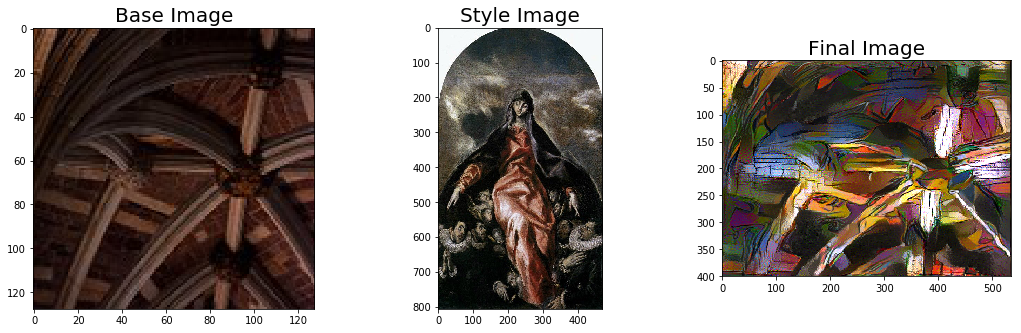

In [31]:
base_image_path_1 = '/kaggle/input/image-classification/images/images/architecure/10037315644_6c99b3350b_m.jpg'
plt.figure(figsize=(30,30))
plt.subplot(5,5,1)
plt.title("Base Image",fontsize=20)
img_base = load_img(base_image_path_1)
plt.imshow(img_base)

style_image_path_1 = '/kaggle/input/best-artworks-of-all-time/images/images/El_Greco/El_Greco_12.jpg'
plt.subplot(5,5,1+1)
plt.title("Style Image",fontsize=20)
img_style = load_img(style_image_path_1)
plt.imshow(img_style)

plt.subplot(5,5,1+2)
imgg = Run_StyleTransfer(base_image_path_1, style_image_path_1)
plt.title("Final Image",fontsize=20)
plt.imshow(imgg)

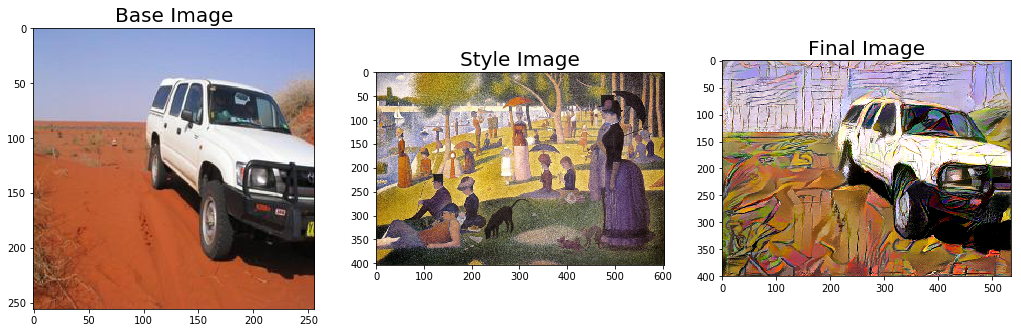

In [32]:
base_image_path_2 = '/kaggle/input/image-classification/images/images/travel and  adventure/Places365_val_00005742.jpg'
plt.figure(figsize=(30,30))
plt.subplot(5,5,1)
plt.title("Base Image",fontsize=20)
img_base = load_img(base_image_path_2)
plt.imshow(img_base)

style_image_path_2 = '/kaggle/input/best-artworks-of-all-time/images/images/Georges_Seurat/Georges_Seurat_23.jpg'
plt.subplot(5,5,1+1)
plt.title("Style Image",fontsize=20)
img_style = load_img(style_image_path_2)
plt.imshow(img_style)

plt.subplot(5,5,1+2)
imga = Run_StyleTransfer(base_image_path_2, style_image_path_2)
plt.title("Final Image",fontsize=20)
plt.imshow(imga)

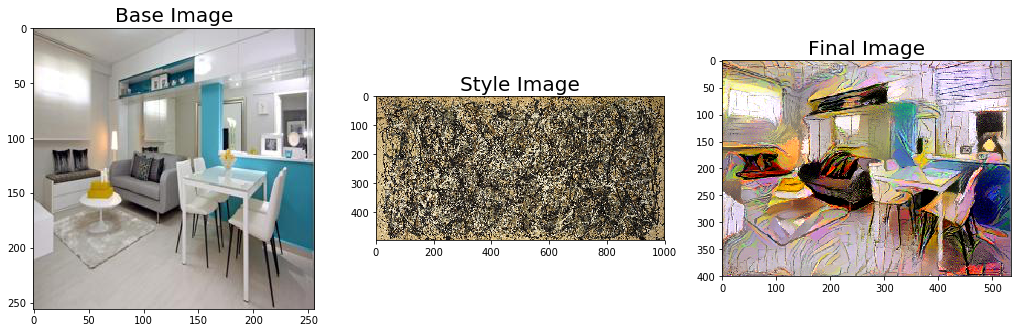

In [33]:
base_image_path_3 = '/kaggle/input/image-classification/images/images/travel and  adventure/Places365_val_00005757.jpg'
plt.figure(figsize=(30,30))
plt.subplot(5,5,1)
plt.title("Base Image",fontsize=20)
img_base = load_img(base_image_path_3)
plt.imshow(img_base)

style_image_path_3 = '/kaggle/input/best-artworks-of-all-time/images/images/Jackson_Pollock/Jackson_Pollock_15.jpg'
plt.subplot(5,5,1+1)
plt.title("Style Image",fontsize=20)
img_style = load_img(style_image_path_3)
plt.imshow(img_style)

plt.subplot(5,5,1+2)
imgy = Run_StyleTransfer(base_image_path_3, style_image_path_3)
plt.title("Final Image",fontsize=20)
plt.imshow(imgy)

# Conclusion
- a deeper neural network could have been used for better style transfer
- increase the number of iterations so as to increase the accuracy
- try cross-validiting with other models by hypertuning
